In [1]:
import pandas as pd
import json
import numpy as np

from sklearn.metrics import f1_score, balanced_accuracy_score, matthews_corrcoef, confusion_matrix, precision_recall_curve

from xgboost import XGBClassifier
import xgboost as xgb
import lightgbm as lgb
from imblearn.ensemble import BalancedRandomForestClassifier

# import packages for hyperparameters tuning
import optuna

import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

/home/dimitra/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-28 16:23:00.745059: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-28 16:23:00.765632: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-28 16:23:00.765651: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-28 16:23:00.766421

In [2]:
model_for_testing = 'protTrans'
df = pd.read_csv('/home/dimitra/master_thesis/Datasets/My_Dataset/proteins_embeddings_' + model_for_testing + '_annotated.csv', index_col=0)

# convert residues to one-hot encode
df_res = pd.get_dummies(df['residue_1l'])
# Convert boolean values to numeric values
df_res = df_res.astype(int)

df = df.merge(df_res, left_index=True, right_index=True, how='inner')
df.insert(len(df.columns)-1, 'is_IBS', df.pop('is_IBS'))
print(df.shape)

f = open('/home/dimitra/master_thesis/Datasets/Uniprot_Dataset/split_proteins.json')
dict_proteins_split = json.load(f)
f.close()

df_train = df[df.uniprot_id.isin(dict_proteins_split['train'])]
df_test = df[df.uniprot_id.isin(dict_proteins_split['test'])]
df_val = df[df.uniprot_id.isin(dict_proteins_split['val'])]

positive_samples = df_train['is_IBS'].sum()
negative_samples = len(df_train) - positive_samples

ratio = negative_samples / positive_samples

X_train, y_train = df_train.drop(['uniprot_id', 'residue_1l', 'is_IBS'], axis=1, inplace=False), df_train['is_IBS']
X_test, y_test = df_test.drop(['uniprot_id', 'residue_1l', 'is_IBS'], axis=1, inplace=False), df_test['is_IBS']
X_val, y_val = df_val.drop(['uniprot_id', 'residue_1l', 'is_IBS'], axis=1, inplace=False), df_val['is_IBS']

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
import gc

del df, df_train, df_test, df_val, df_res
gc.collect()

X_train, y_train = X_train.values, y_train.values
X_test, y_test = X_test.values, y_test.values

(325943, 1047)
(297295, 1044)
(7776, 1044)
(5967, 1044)


### Optimize LGBM


In [3]:
# define the params and the metric function
def objective(trial):
  params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'binary_logloss',
    'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
    "max_depth": trial.suggest_int("max_depth", 1, 31, step=2),
    "scale_pos_weight": trial.suggest_float("scale_pos_weight", ratio-5, ratio+5),
    'num_leaves': trial.suggest_int('num_leaves', 20, 100),
    'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
    'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
    'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
    'lambda_l1': trial.suggest_float('lambda_l1', 0, 1),
    'lambda_l2': trial.suggest_float('lambda_l2', 0, 1),
    "num_iterations": trial.suggest_int("num_iterations", 100, 2000, step=100),
    'verbosity': -1,
    'device_type': 'cpu',
    'random_state': 42,
    'n_jobs': -1
}
  model = lgb.train(params, lgb.Dataset(X_train, y_train))

  preds = model.predict(X_val)
  pred_labels = np.rint(preds)

  f1 =  f1_score(y_val, pred_labels)

  return f1

# start fine-tuning and search for the optimal hyper-params
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-03-28 16:23:59,494] A new study created in memory with name: no-name-4437b2ff-7f48-4af3-8409-bcd6a9e3c865
[I 2024-03-28 16:27:24,981] Trial 0 finished with value: 0.5361952861952861 and parameters: {'learning_rate': 0.006074219550826093, 'max_depth': 9, 'scale_pos_weight': 32.14284292231546, 'num_leaves': 36, 'feature_fraction': 0.860681142606906, 'bagging_fraction': 0.7712060811379233, 'bagging_freq': 8, 'lambda_l1': 0.62956544175204, 'lambda_l2': 0.03631846152524043, 'num_iterations': 1800}. Best is trial 0 with value: 0.5361952861952861.
[I 2024-03-28 16:28:12,767] Trial 1 finished with value: 0.4588715159755269 and parameters: {'learning_rate': 0.010995749081307779, 'max_depth': 3, 'scale_pos_weight': 35.05340905931346, 'num_leaves': 36, 'feature_fraction': 0.856104424936892, 'bagging_fraction': 0.9700474987709665, 'bagging_freq': 4, 'lambda_l1': 0.35422701611246976, 'lambda_l2': 0.3026931698249439, 'num_iterations': 1500}. Best is trial 0 with value: 0.5361952861952861.
[I

Number of finished trials:  200
Best trial:
  Value: 0.6333113890717578
  Params: 
    learning_rate: 0.01380605288076058
    max_depth: 31
    scale_pos_weight: 34.683464805409834
    num_leaves: 84
    feature_fraction: 0.7271452869823677
    bagging_fraction: 0.755295392779871
    bagging_freq: 7
    lambda_l1: 0.35802780689923713
    lambda_l2: 0.8098299642862663
    num_iterations: 2000


In [5]:
clf = lgb.LGBMClassifier(device_type= 'cpu',
    verbosity= -1,
    random_state= 42,
    n_jobs= -1, 
    # **params
    **study.best_trial.params
    )

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print()
print("----------- Model ---------")
print(model_for_testing)
print()
print('F1 score: %.3f ' % f1_score(y_test, y_pred))
print('MCC: %.3f ' % matthews_corrcoef(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
print(cm)


----------- Model ---------
protTrans

F1 score: 0.674 
MCC: 0.634 
      0    1
0  6637  275
1   285  579


### Optimize XGBoost

In [15]:
xgb_clf = XGBClassifier()

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_val, label=y_val)

trials = {}
# 1. Define an objective function to be maximized.
def objective(trial):
    param = {
        'objective': 'binary:logistic',
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
        "gamma": trial.suggest_float("gamma", 0.7, 1.0, step=0.1),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-2, 10.),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "max_depth": trial.suggest_int("max_depth", 1, 31, step=2),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", ratio-5, ratio+5),
    }

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)

    f1 =  f1_score(y_val, pred_labels)
    mcc =  matthews_corrcoef(y_val, pred_labels)
    conf_matrix = confusion_matrix(y_val, pred_labels)

    trials[trial.number] = [f1, mcc, conf_matrix]    
    return f1

# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

[I 2024-01-23 13:26:53,408] A new study created in memory with name: no-name-c84a1349-96ae-4551-861d-273f68315eef
[I 2024-01-23 13:27:18,379] Trial 0 finished with value: 0.4389920424403183 and parameters: {'learning_rate': 0.0012641991782402873, 'booster': 'gbtree', 'gamma': 1.0, 'lambda': 1.1668214802791591e-05, 'reg_alpha': 2.280211019758367, 'subsample': 0.8843771568323349, 'colsample_bytree': 0.7232707745585862, 'max_depth': 13, 'min_child_weight': 6, 'scale_pos_weight': 36.41220956670108}. Best is trial 0 with value: 0.4389920424403183.
[I 2024-01-23 13:27:50,182] Trial 1 finished with value: 0.30665380906460943 and parameters: {'learning_rate': 0.003098403261906665, 'booster': 'dart', 'gamma': 1.0, 'lambda': 3.0372221662472634e-06, 'reg_alpha': 5.038250753174373, 'subsample': 0.5362969263049406, 'colsample_bytree': 0.864917218190785, 'max_depth': 31, 'min_child_weight': 5, 'scale_pos_weight': 31.435649442807488}. Best is trial 0 with value: 0.4389920424403183.
[I 2024-01-23 13:2

In [16]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  200
Best trial:
  Value: 0.5014343086632244
  Params: 
    learning_rate: 0.018532546571990664
    booster: gbtree
    gamma: 0.7999999999999999
    lambda: 0.00010690298719347456
    reg_alpha: 9.353729121385786
    subsample: 0.6835366299983335
    colsample_bytree: 0.7145795902754652
    max_depth: 11
    min_child_weight: 4
    scale_pos_weight: 38.948239592913026


In [19]:
xgb_clf = XGBClassifier(objective='binary:logistic', **trial.params, n_jobs=-1, random_state=42)

xgb_clf.fit(X_train, y_train)

# evaluate model on the traindataset
ypred = xgb_clf.predict(X_test)

print('F1 score: %.3f ' % f1_score(y_test, ypred))
print('MCC: %.3f ' % matthews_corrcoef(y_test, ypred))

cm = confusion_matrix(y_test, ypred)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
print(cm)

F1 score: 0.581 
MCC: 0.526 
      0    1
0  6450  462
1   321  543


### Optimize BalancedRandomForest

In [31]:
import sklearn.model_selection

trials = {}
# 1. Define an objective function to be maximized.
def objective(trial):
    params_brf = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
        "max_depth": trial.suggest_int("max_depth", 1, 31, step=2),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "max_features": trial.suggest_float("max_features", 0.1, 1.0, log=True),
    }

    brf = BalancedRandomForestClassifier(replacement=True, sampling_strategy= "all", **params_brf, n_jobs=-1)
    score = sklearn.model_selection.cross_val_score(brf, X_train, y_train, scoring="f1", n_jobs=-1, cv=3).mean()

    return score

# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

[I 2024-01-23 15:18:08,348] A new study created in memory with name: no-name-cfea11f8-97e7-4167-8270-32d20289face
[I 2024-01-23 15:19:09,036] Trial 0 finished with value: 0.30103468279674267 and parameters: {'n_estimators': 278, 'criterion': 'gini', 'max_depth': 19, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_features': 0.1995372108787425}. Best is trial 0 with value: 0.30103468279674267.
[I 2024-01-23 15:20:46,315] Trial 1 finished with value: 0.26135000520174106 and parameters: {'n_estimators': 152, 'criterion': 'gini', 'max_depth': 17, 'min_samples_split': 10, 'min_samples_leaf': 9, 'max_features': 0.8019260177182596}. Best is trial 0 with value: 0.30103468279674267.
[I 2024-01-23 15:24:32,286] Trial 2 finished with value: 0.24979906994176757 and parameters: {'n_estimators': 371, 'criterion': 'entropy', 'max_depth': 25, 'min_samples_split': 17, 'min_samples_leaf': 20, 'max_features': 0.9113880731483077}. Best is trial 0 with value: 0.30103468279674267.
[I 2024-01-23 15:25:3

In [32]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  200
Best trial:
  Value: 0.34060937812551556
  Params: 
    n_estimators: 476
    criterion: gini
    max_depth: 31
    min_samples_split: 9
    min_samples_leaf: 1
    max_features: 0.10002741468568423


In [34]:
trial = study.best_trial
brf_clf = BalancedRandomForestClassifier(replacement=True, sampling_strategy= "all", n_jobs=-1, **trial.params)
brf_clf.fit(X_train, y_train)
ypred = brf_clf.predict(X_test)

print('F1 score: %.3f ' % f1_score(y_test, ypred))
print('MCC: %.3f ' % matthews_corrcoef(y_test, ypred))
print('Balanced accuracy: %.3f ' % balanced_accuracy_score(y_test, ypred))

cm = confusion_matrix(y_test, ypred)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
print(cm)

F1 score: 0.526 
MCC: 0.470 
Balanced accuracy: 0.790 
      0    1
0  6084  828
1   260  604


### Optimize SLP

In [4]:
def objective(trial):
    # Define hyperparameters to be optimized
    params = {
        'hidden_layer_sizes': trial.suggest_int('hidden_layer_sizes', 1, 1000),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid']),
        'optimizer': trial.suggest_categorical('optimizer', ['adam', 'sgd']),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),
        'epochs': 20,
    }

    # Build the MLP model with the suggested hyperparameters
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units=params['hidden_layer_sizes'], activation=params['activation'], input_dim=X_train.shape[1]))
    model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))  # Assuming binary classification

    # Compile the model
    if params['optimizer'] == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
    else:
        optimizer = tf.keras.optimizers.SGD(learning_rate=params['learning_rate'])

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model on the training set
    model.fit(X_train, y_train, epochs=params['epochs'], verbose=0)

    # Make predictions on the validation set
    y_pred_proba = model.predict(X_val)
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Calculate accuracy on the validation set
    f1 = f1_score(y_val, y_pred)

    return f1  # Optimize for accuracy, so minimize the error

# Create an Optuna study
study = optuna.create_study(direction='maximize')

# Optimize the objective function
study.optimize(objective, n_trials=50)

# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

[I 2024-01-24 18:47:50,782] A new study created in memory with name: no-name-a9e8bdd1-820f-4ae9-8e5a-389251680820
2024-01-24 18:47:50.802899: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-24 18:47:50.822119: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


187/187 [==============================] - 0s 463us/step


[I 2024-01-24 18:50:53,524] Trial 0 finished with value: 0.0 and parameters: {'hidden_layer_sizes': 620, 'activation': 'sigmoid', 'optimizer': 'sgd', 'learning_rate': 0.0008530257137986239}. Best is trial 0 with value: 0.0.


187/187 [==============================] - 0s 414us/step


[I 2024-01-24 18:53:03,500] Trial 1 finished with value: 0.0 and parameters: {'hidden_layer_sizes': 255, 'activation': 'sigmoid', 'optimizer': 'sgd', 'learning_rate': 0.00023709620469053263}. Best is trial 0 with value: 0.0.


187/187 [==============================] - 0s 513us/step


[I 2024-01-24 19:00:39,315] Trial 2 finished with value: 0.4785772029102668 and parameters: {'hidden_layer_sizes': 825, 'activation': 'sigmoid', 'optimizer': 'adam', 'learning_rate': 0.0001932096755625571}. Best is trial 2 with value: 0.4785772029102668.


187/187 [==============================] - 0s 472us/step


[I 2024-01-24 19:03:00,246] Trial 3 finished with value: 0.27926078028747436 and parameters: {'hidden_layer_sizes': 367, 'activation': 'sigmoid', 'optimizer': 'sgd', 'learning_rate': 0.06293990985744187}. Best is trial 2 with value: 0.4785772029102668.


187/187 [==============================] - 0s 391us/step


[I 2024-01-24 19:06:05,665] Trial 4 finished with value: 0.46376811594202894 and parameters: {'hidden_layer_sizes': 183, 'activation': 'sigmoid', 'optimizer': 'adam', 'learning_rate': 0.00028048341915515735}. Best is trial 2 with value: 0.4785772029102668.


187/187 [==============================] - 0s 317us/step


[I 2024-01-24 19:08:03,553] Trial 5 finished with value: 0.3537158984007525 and parameters: {'hidden_layer_sizes': 89, 'activation': 'sigmoid', 'optimizer': 'adam', 'learning_rate': 3.145934660383375e-05}. Best is trial 2 with value: 0.4785772029102668.


187/187 [==============================] - 0s 499us/step


[I 2024-01-24 19:11:34,257] Trial 6 finished with value: 0.08478802992518703 and parameters: {'hidden_layer_sizes': 787, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.0005348885143326522}. Best is trial 2 with value: 0.4785772029102668.


187/187 [==============================] - 0s 465us/step


[I 2024-01-24 19:14:53,715] Trial 7 finished with value: 0.0 and parameters: {'hidden_layer_sizes': 732, 'activation': 'sigmoid', 'optimizer': 'sgd', 'learning_rate': 5.8166383370084015e-05}. Best is trial 2 with value: 0.4785772029102668.


187/187 [==============================] - 0s 510us/step


[I 2024-01-24 19:21:38,303] Trial 8 finished with value: 0.3805229936880072 and parameters: {'hidden_layer_sizes': 710, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 1.436422641424835e-05}. Best is trial 2 with value: 0.4785772029102668.


187/187 [==============================] - 0s 453us/step


[I 2024-01-24 19:25:28,947] Trial 9 finished with value: 0.010484927916120577 and parameters: {'hidden_layer_sizes': 962, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.00026573007316365557}. Best is trial 2 with value: 0.4785772029102668.


187/187 [==============================] - 0s 483us/step


[I 2024-01-24 19:34:21,323] Trial 10 finished with value: 0.12636695018226002 and parameters: {'hidden_layer_sizes': 985, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.007873985108005549}. Best is trial 2 with value: 0.4785772029102668.


187/187 [==============================] - 0s 286us/step


[I 2024-01-24 19:35:23,404] Trial 11 finished with value: 0.44479004665629857 and parameters: {'hidden_layer_sizes': 12, 'activation': 'sigmoid', 'optimizer': 'adam', 'learning_rate': 0.004560100274340154}. Best is trial 2 with value: 0.4785772029102668.


187/187 [==============================] - 0s 414us/step


[I 2024-01-24 19:40:15,606] Trial 12 finished with value: 0.3720073664825046 and parameters: {'hidden_layer_sizes': 444, 'activation': 'sigmoid', 'optimizer': 'adam', 'learning_rate': 9.812342947595332e-05}. Best is trial 2 with value: 0.4785772029102668.


187/187 [==============================] - 0s 397us/step


[I 2024-01-24 19:43:36,159] Trial 13 finished with value: 0.44246353322528365 and parameters: {'hidden_layer_sizes': 216, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.0035204559176477204}. Best is trial 2 with value: 0.4785772029102668.


187/187 [==============================] - 0s 431us/step


[I 2024-01-24 19:49:02,823] Trial 14 finished with value: 0.4607922392886014 and parameters: {'hidden_layer_sizes': 541, 'activation': 'sigmoid', 'optimizer': 'adam', 'learning_rate': 0.0001332169663328279}. Best is trial 2 with value: 0.4785772029102668.


187/187 [==============================] - 0s 450us/step


[I 2024-01-24 19:56:29,877] Trial 15 finished with value: 0.42769500438212094 and parameters: {'hidden_layer_sizes': 858, 'activation': 'sigmoid', 'optimizer': 'adam', 'learning_rate': 0.0017959807891126582}. Best is trial 2 with value: 0.4785772029102668.


187/187 [==============================] - 0s 411us/step


[I 2024-01-24 20:00:19,184] Trial 16 finished with value: 0.48104956268221566 and parameters: {'hidden_layer_sizes': 295, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.019119842088035098}. Best is trial 16 with value: 0.48104956268221566.


187/187 [==============================] - 0s 404us/step


[I 2024-01-24 20:04:31,782] Trial 17 finished with value: 0.0 and parameters: {'hidden_layer_sizes': 359, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0342069089036136}. Best is trial 16 with value: 0.48104956268221566.


187/187 [==============================] - 0s 434us/step


[I 2024-01-24 20:10:05,135] Trial 18 finished with value: 0.46877409406322285 and parameters: {'hidden_layer_sizes': 569, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.015278711434844532}. Best is trial 16 with value: 0.48104956268221566.


187/187 [==============================] - 0s 409us/step


[I 2024-01-24 20:14:49,987] Trial 19 finished with value: 0.0 and parameters: {'hidden_layer_sizes': 445, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.07430762802306683}. Best is trial 16 with value: 0.48104956268221566.


187/187 [==============================] - 0s 429us/step


[I 2024-01-24 20:20:48,493] Trial 20 finished with value: 0.515527950310559 and parameters: {'hidden_layer_sizes': 635, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.002029554796716754}. Best is trial 20 with value: 0.515527950310559.


187/187 [==============================] - 0s 422us/step


[I 2024-01-24 20:26:52,525] Trial 21 finished with value: 0.4481658692185008 and parameters: {'hidden_layer_sizes': 653, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0169066050931286}. Best is trial 20 with value: 0.515527950310559.


187/187 [==============================] - 0s 458us/step


[I 2024-01-24 20:34:22,820] Trial 22 finished with value: 0.39569049951028407 and parameters: {'hidden_layer_sizes': 865, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0019942481256062417}. Best is trial 20 with value: 0.515527950310559.


187/187 [==============================] - 0s 447us/step


[I 2024-01-24 20:41:41,670] Trial 23 finished with value: 0.4426666666666667 and parameters: {'hidden_layer_sizes': 844, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0006099839110195364}. Best is trial 20 with value: 0.515527950310559.


187/187 [==============================] - 0s 405us/step


[I 2024-01-24 20:45:29,368] Trial 24 finished with value: 0.45871559633027525 and parameters: {'hidden_layer_sizes': 300, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.00875217031953868}. Best is trial 20 with value: 0.515527950310559.


187/187 [==============================] - 0s 402us/step


[I 2024-01-24 20:50:27,816] Trial 25 finished with value: 0.5123595505617978 and parameters: {'hidden_layer_sizes': 490, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.001663125550923563}. Best is trial 20 with value: 0.515527950310559.


187/187 [==============================] - 0s 407us/step


[I 2024-01-24 20:55:19,433] Trial 26 finished with value: 0.4649910233393178 and parameters: {'hidden_layer_sizes': 470, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0020320398318993778}. Best is trial 20 with value: 0.515527950310559.


187/187 [==============================] - 0s 407us/step


[I 2024-01-24 20:59:35,983] Trial 27 finished with value: 0.005256241787122207 and parameters: {'hidden_layer_sizes': 384, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.03236574746281449}. Best is trial 20 with value: 0.515527950310559.


187/187 [==============================] - 0s 422us/step


[I 2024-01-24 21:04:55,392] Trial 28 finished with value: 0.46568201563857514 and parameters: {'hidden_layer_sizes': 542, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.001336855915759036}. Best is trial 20 with value: 0.515527950310559.


187/187 [==============================] - 0s 431us/step


[I 2024-01-24 21:07:52,403] Trial 29 finished with value: 0.13285024154589373 and parameters: {'hidden_layer_sizes': 627, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.0007873092337822035}. Best is trial 20 with value: 0.515527950310559.


187/187 [==============================] - 0s 335us/step


[I 2024-01-24 21:10:25,255] Trial 30 finished with value: 0.45362563237774034 and parameters: {'hidden_layer_sizes': 128, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.004247776679645683}. Best is trial 20 with value: 0.515527950310559.


187/187 [==============================] - 0s 422us/step


[I 2024-01-24 21:16:40,492] Trial 31 finished with value: 0.43744531933508307 and parameters: {'hidden_layer_sizes': 688, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.000424318986253876}. Best is trial 20 with value: 0.515527950310559.


187/187 [==============================] - 0s 442us/step


[I 2024-01-24 21:23:32,157] Trial 32 finished with value: 0.5164923572003217 and parameters: {'hidden_layer_sizes': 776, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0009146523695170536}. Best is trial 32 with value: 0.5164923572003217.


187/187 [==============================] - 0s 435us/step


[I 2024-01-24 21:29:13,646] Trial 33 finished with value: 0.5008025682182985 and parameters: {'hidden_layer_sizes': 589, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0013685103227879327}. Best is trial 32 with value: 0.5164923572003217.


187/187 [==============================] - 0s 443us/step


[I 2024-01-24 21:32:05,515] Trial 34 finished with value: 0.2054176072234763 and parameters: {'hidden_layer_sizes': 593, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.0013295131170595056}. Best is trial 32 with value: 0.5164923572003217.


187/187 [==============================] - 0s 414us/step


[I 2024-01-24 21:37:18,013] Trial 35 finished with value: 0.45367965367965374 and parameters: {'hidden_layer_sizes': 516, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0009167094350966893}. Best is trial 32 with value: 0.5164923572003217.


187/187 [==============================] - 0s 444us/step


[I 2024-01-24 21:44:15,799] Trial 36 finished with value: 0.44177449168207017 and parameters: {'hidden_layer_sizes': 779, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.003638547772803011}. Best is trial 32 with value: 0.5164923572003217.


187/187 [==============================] - 0s 438us/step


[I 2024-01-24 21:50:25,859] Trial 37 finished with value: 0.4456521739130435 and parameters: {'hidden_layer_sizes': 657, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.00032722696835409603}. Best is trial 32 with value: 0.5164923572003217.


187/187 [==============================] - 0s 433us/step


[I 2024-01-24 21:53:38,039] Trial 38 finished with value: 0.28950050968399593 and parameters: {'hidden_layer_sizes': 742, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.0024272570166005833}. Best is trial 32 with value: 0.5164923572003217.


187/187 [==============================] - 0s 465us/step


[I 2024-01-24 22:01:34,514] Trial 39 finished with value: 0.4216315307057746 and parameters: {'hidden_layer_sizes': 935, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.0010575967003254169}. Best is trial 32 with value: 0.5164923572003217.


187/187 [==============================] - 0s 435us/step


[I 2024-01-24 22:04:27,544] Trial 40 finished with value: 0.4066029539530843 and parameters: {'hidden_layer_sizes': 607, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.007006636022726289}. Best is trial 32 with value: 0.5164923572003217.


187/187 [==============================] - 0s 409us/step


[I 2024-01-24 22:08:20,446] Trial 41 finished with value: 0.5077551020408164 and parameters: {'hidden_layer_sizes': 316, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0005823484844110781}. Best is trial 32 with value: 0.5164923572003217.


187/187 [==============================] - 0s 403us/step


[I 2024-01-24 22:12:42,937] Trial 42 finished with value: 0.40805123513266234 and parameters: {'hidden_layer_sizes': 392, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0006380240623107867}. Best is trial 32 with value: 0.5164923572003217.


187/187 [==============================] - 0s 408us/step


[I 2024-01-24 22:17:39,572] Trial 43 finished with value: 0.46840775063184503 and parameters: {'hidden_layer_sizes': 488, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.000394569273337424}. Best is trial 32 with value: 0.5164923572003217.


187/187 [==============================] - 0s 455us/step


[I 2024-01-24 22:24:34,516] Trial 44 finished with value: 0.43548387096774194 and parameters: {'hidden_layer_sizes': 775, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.00015572979136582483}. Best is trial 32 with value: 0.5164923572003217.


187/187 [==============================] - 0s 421us/step


[I 2024-01-24 22:30:48,484] Trial 45 finished with value: 0.4774083546462063 and parameters: {'hidden_layer_sizes': 684, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.002895716954862769}. Best is trial 32 with value: 0.5164923572003217.


187/187 [==============================] - 0s 453us/step


[I 2024-01-24 22:38:29,166] Trial 46 finished with value: 0.49247822644497236 and parameters: {'hidden_layer_sizes': 902, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.0012067477310520498}. Best is trial 32 with value: 0.5164923572003217.


187/187 [==============================] - 0s 404us/step


[I 2024-01-24 22:42:26,377] Trial 47 finished with value: 0.4651162790697674 and parameters: {'hidden_layer_sizes': 328, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 6.890527262208497e-05}. Best is trial 32 with value: 0.5164923572003217.


187/187 [==============================] - 0s 415us/step


[I 2024-01-24 22:47:06,218] Trial 48 finished with value: 0.4217081850533808 and parameters: {'hidden_layer_sizes': 431, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0005491041046494668}. Best is trial 32 with value: 0.5164923572003217.


187/187 [==============================] - 0s 385us/step


[I 2024-01-24 22:49:01,428] Trial 49 finished with value: 0.0 and parameters: {'hidden_layer_sizes': 185, 'activation': 'sigmoid', 'optimizer': 'sgd', 'learning_rate': 0.00023602323234034114}. Best is trial 32 with value: 0.5164923572003217.


Best hyperparameters: {'hidden_layer_sizes': 776, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0009146523695170536}


In [6]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  50
Best trial:
  Value: 0.5164923572003217
  Params: 
    hidden_layer_sizes: 776
    activation: relu
    optimizer: adam
    learning_rate: 0.0009146523695170536


In [8]:
#  Trial 2 finished with value: 0.5825958702064896 and parameters: {'hidden_layer_sizes': 412, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.00040448886589716375}. Best is trial 1 with value: 0.005256241787122207.
metrics = [
  tf.keras.metrics.TruePositives(name='tp'),
  tf.keras.metrics.FalsePositives(name='fp'),
  tf.keras.metrics.TrueNegatives(name='tn'),
  tf.keras.metrics.FalseNegatives(name='fn'), 
  tf.keras.metrics.Precision(name='precision'),
  tf.keras.metrics.Recall(name='recall'),
]

# Build the final model with the best hyperparameters on the entire training set
final_model = tf.keras.models.Sequential()
final_model.add(tf.keras.layers.Dense(units=776, activation='relu', input_dim=X_train.shape[1]))
final_model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))  # Assuming binary classification

# Compile the final model
final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0009146523695170536), loss='binary_crossentropy', metrics=metrics)

# Train the final model on the entire training set
final_model.fit(X_train, y_train, epochs=20)

ypred = final_model.predict(X_test)

print('F1 score: %.3f ' % f1_score(y_test, ypred > 0.5))
print('MCC: %.3f ' % matthews_corrcoef(y_test, ypred > 0.5))

cm = confusion_matrix(y_test, ypred > 0.5)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
print(cm)

Epoch 1/20
9291/9291 [==============================] - 22s 2ms/step - loss: 0.0514 - tp: 4260.0000 - fp: 1611.0000 - tn: 287372.0000 - fn: 4052.0000 - precision: 0.7256 - recall: 0.5125
Epoch 2/20
9291/9291 [==============================] - 22s 2ms/step - loss: 0.0326 - tp: 5984.0000 - fp: 1379.0000 - tn: 287604.0000 - fn: 2328.0000 - precision: 0.8127 - recall: 0.7199
Epoch 3/20
9291/9291 [==============================] - 22s 2ms/step - loss: 0.0225 - tp: 6801.0000 - fp: 1001.0000 - tn: 287982.0000 - fn: 1511.0000 - precision: 0.8717 - recall: 0.8182
Epoch 4/20
9291/9291 [==============================] - 22s 2ms/step - loss: 0.0159 - tp: 7336.0000 - fp: 677.0000 - tn: 288306.0000 - fn: 976.0000 - precision: 0.9155 - recall: 0.8826
Epoch 5/20
9291/9291 [==============================] - 22s 2ms/step - loss: 0.0116 - tp: 7634.0000 - fp: 510.0000 - tn: 288473.0000 - fn: 678.0000 - precision: 0.9374 - recall: 0.9184
Epoch 6/20
9291/9291 [==============================] - 22s 2ms/step 

### Optimize MLP

In [ ]:
def create_model(trial):
    # We optimize the numbers of layers, their units and weight decay parameter.
    n_layers = trial.suggest_int("n_layers", 1, 4)
    weight_decay = trial.suggest_float("weight_decay", 1e-10, 1e-3, log=True)
    num_hidden = trial.suggest_int("n_units_l_input", 4, 512, log=True)
    model = tf.keras.Sequential()
    model.add(
        tf.keras.layers.Dense(
            num_hidden,
            input_shape=(X_train.shape[-1],),
            activation=trial.suggest_categorical('activation_input', ['relu', 'tanh', 'sigmoid']),
        )
    )
    model.add(tf.keras.layers.Flatten())

    for i in range(n_layers):
        num_hidden = trial.suggest_int("n_units_l{}".format(i), 4, 512, log=True)
        model.add(
            tf.keras.layers.Dense(
                num_hidden,
                activation=trial.suggest_categorical('activation_{}'.format(i), ['relu', 'tanh', 'sigmoid']),
                kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
            )
        )
    model.add(
        tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(weight_decay), activation="sigmoid")
    )
    return model

def create_optimizer(trial):
    # We optimize the choice of optimizers as well as their parameters.
    kwargs = {}
    optimizer_options = ["Adam", "SGD"]
    optimizer_selected = trial.suggest_categorical("optimizer", optimizer_options)
    if optimizer_selected == "Adam":
        kwargs["learning_rate"] = trial.suggest_float("adam_learning_rate", 1e-5, 1e-1, log=True)
    elif optimizer_selected == "SGD":
        kwargs["learning_rate"] = trial.suggest_float(
            "sgd_opt_learning_rate", 1e-5, 1e-1, log=True
        )
        kwargs["momentum"] = trial.suggest_float("sgd_opt_momentum", 1e-5, 1e-1, log=True)

    optimizer = getattr(tf.optimizers, optimizer_selected)(**kwargs)
    return optimizer

def learn(model, optimizer, X, y, trial):    
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=[tf.keras.metrics.Precision(), 
                           tf.keras.metrics.Recall(), 
                           tf.keras.metrics.F1Score(name='f1_score')])
    
    y = tf.cast(y, tf.float32)

    model.fit(X, y, 
              epochs=trial.suggest_int("epochs", 10, 30), 
              batch_size=trial.suggest_int("batch_size", 128, 512))

    
def objective(trial):

    # Build model and optimizer.
    model = create_model(trial)
    optimizer = create_optimizer(trial)

    # Training and validating cycle.
    with tf.device("/GPU:0"):
        # for _ in range(20):
        learn(model, optimizer, X_train, y_train, trial)

        # Make predictions on the validation set
        y_pred_proba = model.predict(X_val.values)
        y_pred = (y_pred_proba > 0.5).astype(int)

        # Calculate F1 score on the validation set
        f1 = f1_score(y_val.values, y_pred)

    # Return last validation accuracy.
    return f1

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

In [13]:
print("Number of trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of trials:  50
Best trial:
  Value: 0.6041055718475073
  Params: 
    n_layers: 3
    weight_decay: 2.6955177810398497e-08
    n_units_l_input: 274
    activation_input: relu
    n_units_l0: 42
    activation_0: tanh
    n_units_l1: 53
    activation_1: relu
    n_units_l2: 49
    activation_2: tanh
    optimizer: Adam
    adam_learning_rate: 0.0018389654970221772
    epochs: 14
    batch_size: 283


In [19]:
params = {
  'n_layers': 3,
  'weight_decay': 2.6955177810398497e-08,
  'n_units_l_input': 274,
  'activation_input': 'relu',
  'n_units_l0': 42,
  'activation_0': 'tanh',
  'n_units_l1': 53,
  'activation_1': 'relu',
  'n_units_l2': 49,
  'activation_2': 'tanh',
  'optimizer': 'Adam',
  'adam_learning_rate': 0.0018389654970221772,
  'epochs': 14,
  'batch_size': 283,
}

In [20]:
model_mlp = tf.keras.Sequential()

model_mlp.add(tf.keras.layers.Dense(params['n_units_l_input'], 
                                    input_shape=(X_train.shape[-1],), 
                                    activation=params['activation_input']))
model_mlp.add(tf.keras.layers.Flatten())

for i in range(params['n_layers']):
  model_mlp.add(tf.keras.layers.Dense(
                params['n_units_l{}'.format(i)],
                activation=params['activation_{}'.format(i)],
                kernel_regularizer=tf.keras.regularizers.l2(params['weight_decay']))
            )
model_mlp.add(
        tf.keras.layers.Dense(1, 
                              kernel_regularizer=tf.keras.regularizers.l2(params['weight_decay']), 
                              activation="sigmoid")
    )


model_mlp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params['adam_learning_rate']),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=[tf.keras.metrics.Precision(), 
                           tf.keras.metrics.Recall()])
y = tf.cast(y_train, tf.float32)

model_mlp.fit(X_train, y, 
              epochs=params['epochs'], 
              batch_size=params['batch_size'])

Epoch 1/14


/home/dimitra/miniconda3/lib/python3.11/site-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1051/1051 [==============================] - 2s 2ms/step - loss: 0.0533 - precision_6: 0.6947 - recall_6: 0.4975
Epoch 2/14
1051/1051 [==============================] - 2s 2ms/step - loss: 0.0332 - precision_6: 0.7901 - recall_6: 0.7156
Epoch 3/14
1051/1051 [==============================] - 2s 2ms/step - loss: 0.0251 - precision_6: 0.8273 - recall_6: 0.7980
Epoch 4/14
1051/1051 [==============================] - 2s 2ms/step - loss: 0.0198 - precision_6: 0.8627 - recall_6: 0.8493
Epoch 5/14
1051/1051 [==============================] - 2s 2ms/step - loss: 0.0161 - precision_6: 0.8895 - recall_6: 0.8793
Epoch 6/14
1051/1051 [==============================] - 2s 2ms/step - loss: 0.0134 - precision_6: 0.9069 - recall_6: 0.9039
Epoch 7/14
1051/1051 [==============================] - 2s 2ms/step - loss: 0.0116 - precision_6: 0.9186 - recall_6: 0.9175
Epoch 8/14
1051/1051 [==============================] - 2s 2ms/step - loss: 0.0098 - precision_6: 0.9303 - recall_6: 0.9340
Epoch 9/14
1051/105

In [21]:
 # Make predictions on the validation set
y_pred_proba = model_mlp.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

print('F1 score: %.3f ' % f1_score(y_test, y_pred > 0.5))
print('MCC: %.3f ' % matthews_corrcoef(y_test, y_pred > 0.5))

cm = confusion_matrix(y_test, y_pred > 0.5)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
print(cm)

243/243 [==============================] - 0s 410us/step
F1 score: 0.680 
MCC: 0.647 
      0    1
0  6730  182
1   325  539


In [22]:
model_mlp.save("best_model_protTrans_new")

INFO:tensorflow:Assets written to: best_model_protTrans_new/assets


INFO:tensorflow:Assets written to: best_model_protTrans_new/assets


### Plot Tensorflow model

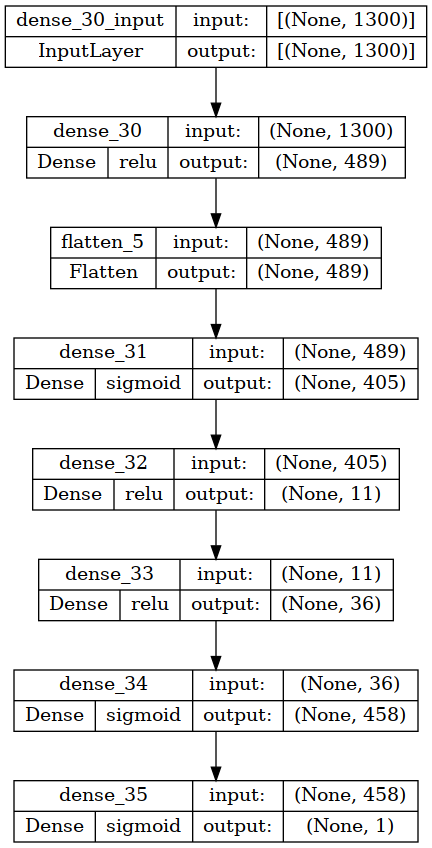

In [3]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import F1Score
import tensorflow as tf

model_for_testing = 'esm_new'
model = tf.keras.models.load_model('/home/dimitra/master_thesis/models/best_model_esm_new')

plot_model(
    model,
    to_file='model_plot.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=96,
    show_layer_activations=True,
)